In [106]:
import fastf1 as ff1
from fastf1 import plotting
from matplotlib import pyplot as plt
from matplotlib.pyplot import figure
import seaborn as sns
import pandas as pd
from scipy import stats
import numpy as np
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
%matplotlib inline

In [107]:
# Setup plotting
plotting.setup_mpl()

# Enable the cache
ff1.Cache.enable_cache('ff1') 

# Get rid of some pandas warnings that are not relevant for us at the moment
pd.options.mode.chained_assignment = None 

In [108]:
#load our mapping chart, this is for later
mapping_path = "ff1_data/gp_to_iracing_mapping.csv"
mapping = pd.read_csv(mapping_path, index_col = 0)
#mapping

In [109]:
#important note - initially I actually pulled these from csvs, but I realized that it lost the fidelity of the dtypes. 
#if you are pulling from CSVs, you're going to have to fix the objects to display as timedeltas. Here's an example
f1_silverstone_csv_data = pd.read_csv("ff1_data/f1_data/british_gp_2021.csv", index_col = 0)
f1_silverstone_csv_data.dtypes

Time                   object
DriverNumber            int64
LapTime                object
LapNumber             float64
Stint                 float64
PitOutTime             object
PitInTime              object
Sector1Time            object
Sector2Time            object
Sector3Time            object
Sector1SessionTime     object
Sector2SessionTime     object
Sector3SessionTime     object
SpeedI1               float64
SpeedI2               float64
SpeedFL               float64
SpeedST               float64
Compound               object
TyreLife              float64
FreshTyre                bool
LapStartTime           object
Team                   object
Driver                 object
TrackStatus             int64
IsAccurate               bool
dtype: object

In [110]:
#load our f1 data
f1_session = ff1.get_session(2021, 'Silverstone', 'R')
f1_data = f1_session.load_laps(with_telemetry=True)
f1_data.dtypes

core           INFO 	Loading laps for British Grand Prix - Race [v2.1.13]
api            INFO 	Using cached data for timing_data
api            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
api            INFO 	Using cached data for driver_info
api            INFO 	Using cached data for session_status_data
api            INFO 	Using cached data for track_status_data
api            INFO 	Using cached data for car_data
api            INFO 	Using cached data for position_data
api            INFO 	Using cached data for weather_data
core           INFO 	Loaded data for 20 drivers: ['4', '10', '22', '31', '63', '77', '9', '16', '11', '3', '55', '7', '33', '14', '18', '99', '6', '44', '5', '47']


Time                  timedelta64[ns]
DriverNumber                   object
LapTime               timedelta64[ns]
LapNumber                     float64
Stint                         float64
PitOutTime            timedelta64[ns]
PitInTime             timedelta64[ns]
Sector1Time           timedelta64[ns]
Sector2Time           timedelta64[ns]
Sector3Time           timedelta64[ns]
Sector1SessionTime    timedelta64[ns]
Sector2SessionTime    timedelta64[ns]
Sector3SessionTime    timedelta64[ns]
SpeedI1                       float64
SpeedI2                       float64
SpeedFL                       float64
SpeedST                       float64
Compound                       object
TyreLife                      float64
FreshTyre                      object
LapStartTime          timedelta64[ns]
Team                           object
Driver                         object
TrackStatus                    object
IsAccurate                     object
LapStartDate           datetime64[ns]
dtype: objec

In [111]:
# we probably only need a few columns from here, since there's so many (not really too necessary)
wanted_columns = ['DriverNumber', 'LapNumber', 'LapTime', 'Sector1Time', 'Sector2Time', 'Sector3Time', 'Team', 'Driver', 'Stint']
f1_data_clean = f1_data[wanted_columns]
f1_data = f1_data_clean
f1_data

,DriverNumber,LapNumber,LapTime,Sector1Time,Sector2Time,Sector3Time,Team,Driver,Stint
0,33,0.0,NaT,NaT,NaT,NaT,Red Bull,VER,1.0
1,44,1.0,NaT,NaT,0 days 00:00:40.610000,0 days 00:00:52.926000,Mercedes,HAM,1.0
2,44,2.0,NaT,0 days 00:00:43.800000,0 days 00:01:10.685000,0 days 00:00:43.657000,Mercedes,HAM,1.0
3,44,3.0,NaT,NaT,0 days 00:01:15.154000,0 days 00:01:08.446000,Mercedes,HAM,2.0
4,44,4.0,NaT,0 days 00:01:33.760000,0 days 00:00:37.907000,0 days 00:00:25.599000,Mercedes,HAM,2.0
...,...,...,...,...,...,...,...,...,...
965,11,47.0,0 days 00:01:30.958000,0 days 00:00:29.325000,0 days 00:00:36.711000,0 days 00:00:24.922000,Red Bull,PER,6.0
966,11,48.0,0 days 00:01:30,0 days 00:00:29.061000,0 days 00:00:36.538000,0 days 00:00:24.401000,Red Bull,PER,6.0
967,11,49.0,0 days 00:01:58.246000,0 days 00:00:51.009000,0 days 00:00:40.418000,0 days 00:00:26.819000,Red Bull,PER,7.0
968,11,50.0,0 days 00:01:28.617000,0 days 00:00:28.547000,0 days 00:00:35.631000,0 days 00:00:24.439000,Red Bull,PER,7.0


In [112]:
#we also see some NAs in the data. We should get rid of those first.
f1_data = f1_data.dropna()

In [113]:
#load our iracing data for silverstone, this is race data only. 
#this data was mined by myself using html requests on iRacing's servers. Maybe a tutorial later on?
iracing_data_path = "ff1_data/3529#Grand_Prix_Series/1#Silverstone_Circuit#Grand_Prix/3529_1_lap_data.csv"
iracing_data = pd.read_csv(iracing_data_path, index_col = 0)

#iRacing displays as ms*10, probably to record if two laps are faster by one extra digit
#We have to make it display only as ms, for later when we convert it to a timedelta
iracing_data['lap_time'] = iracing_data['lap_time']/10

iracing_data
#for silverstone we captured 127.5k laps! that's 131x the amount of total laps in the race this past year at Silverstone.

,weather_temp_value,custid,oldirating,carid,lap_time,ccName,subsessionid,lapnum,flags
0,67.654999,10041,3022,145,100881.7,Mercedes-AMG+W12+E+Performance,43291524,1,8196
1,67.654999,10041,3022,145,90765.0,Mercedes-AMG+W12+E+Performance,43291524,2,0
2,67.654999,10041,3022,145,89866.8,Mercedes-AMG+W12+E+Performance,43291524,3,0
3,67.654999,10041,3022,145,90491.2,Mercedes-AMG+W12+E+Performance,43291524,4,0
4,67.654999,10041,3022,145,90287.2,Mercedes-AMG+W12+E+Performance,43291524,5,0
...,...,...,...,...,...,...,...,...,...
127592,69.697540,701801,2250,145,90019.3,Mercedes-AMG+W12+E+Performance,43372005,27,0
127593,69.697540,701801,2250,145,89133.8,Mercedes-AMG+W12+E+Performance,43372005,28,4
127594,69.697540,701801,2250,145,88461.5,Mercedes-AMG+W12+E+Performance,43372005,29,16384
127595,73.401978,701801,2252,145,101737.5,Mercedes-AMG+W12+E+Performance,43373694,1,8192


In [114]:
#iracing has these flags that we should get rid of, for offtracks, damage, etc. they're essentially invalid laps
iracing_data = iracing_data[iracing_data['flags'] == 0]
iracing_data

,weather_temp_value,custid,oldirating,carid,lap_time,ccName,subsessionid,lapnum,flags
1,67.654999,10041,3022,145,90765.0,Mercedes-AMG+W12+E+Performance,43291524,2,0
2,67.654999,10041,3022,145,89866.8,Mercedes-AMG+W12+E+Performance,43291524,3,0
3,67.654999,10041,3022,145,90491.2,Mercedes-AMG+W12+E+Performance,43291524,4,0
4,67.654999,10041,3022,145,90287.2,Mercedes-AMG+W12+E+Performance,43291524,5,0
5,67.654999,10041,3022,145,92588.9,Mercedes-AMG+W12+E+Performance,43291524,6,0
...,...,...,...,...,...,...,...,...,...
127584,69.697540,701801,2250,145,89307.2,Mercedes-AMG+W12+E+Performance,43372005,19,0
127585,69.697540,701801,2250,145,89119.6,Mercedes-AMG+W12+E+Performance,43372005,20,0
127586,69.697540,701801,2250,145,88867.2,Mercedes-AMG+W12+E+Performance,43372005,21,0
127591,69.697540,701801,2250,145,88766.7,Mercedes-AMG+W12+E+Performance,43372005,26,0


In [115]:
#this converts it into a timedelta
iracing_data['lap_time_timedelta'] = iracing_data['lap_time'].map(lambda x: pd.to_timedelta(x, unit = "ms"))
iracing_data

,weather_temp_value,custid,oldirating,carid,lap_time,ccName,subsessionid,lapnum,flags,lap_time_timedelta
1,67.654999,10041,3022,145,90765.0,Mercedes-AMG+W12+E+Performance,43291524,2,0,0 days 00:01:30.765000
2,67.654999,10041,3022,145,89866.8,Mercedes-AMG+W12+E+Performance,43291524,3,0,0 days 00:01:29.866800
3,67.654999,10041,3022,145,90491.2,Mercedes-AMG+W12+E+Performance,43291524,4,0,0 days 00:01:30.491200
4,67.654999,10041,3022,145,90287.2,Mercedes-AMG+W12+E+Performance,43291524,5,0,0 days 00:01:30.287200
5,67.654999,10041,3022,145,92588.9,Mercedes-AMG+W12+E+Performance,43291524,6,0,0 days 00:01:32.588900
...,...,...,...,...,...,...,...,...,...,...
127584,69.697540,701801,2250,145,89307.2,Mercedes-AMG+W12+E+Performance,43372005,19,0,0 days 00:01:29.307200
127585,69.697540,701801,2250,145,89119.6,Mercedes-AMG+W12+E+Performance,43372005,20,0,0 days 00:01:29.119600
127586,69.697540,701801,2250,145,88867.2,Mercedes-AMG+W12+E+Performance,43372005,21,0,0 days 00:01:28.867200
127591,69.697540,701801,2250,145,88766.7,Mercedes-AMG+W12+E+Performance,43372005,26,0,0 days 00:01:28.766700


In [116]:
#we're not even comparing apples to apples here either, who set the fastest lap? 
f1_data[f1_data['LapTime'] == min(f1_data['LapTime'])]
#Perez set the fastest lap on lap 50/52, to steal the fastest lap point away. So who set the fastest merc lap?

,DriverNumber,LapNumber,LapTime,Sector1Time,Sector2Time,Sector3Time,Team,Driver,Stint
968,11,50.0,0 days 00:01:28.617000,0 days 00:00:28.547000,0 days 00:00:35.631000,0 days 00:00:24.439000,Red Bull,PER,7.0


In [117]:
f1_data_merc = f1_data[f1_data['Team'] == 'Mercedes']
f1_data_merc[f1_data_merc['LapTime'] == min(f1_data_merc['LapTime'])]
#Hamilton set the fastest lap for Merc on lap 45 with a 1:29.6

,DriverNumber,LapNumber,LapTime,Sector1Time,Sector2Time,Sector3Time,Team,Driver,Stint
45,44,45.0,0 days 00:01:29.699000,0 days 00:00:28.698000,0 days 00:00:36.382000,0 days 00:00:24.619000,Mercedes,HAM,3.0


In [118]:
#how about iRacing's data? are cars on iracing faster?
min(iracing_data.lap_time_timedelta)

Timedelta('0 days 00:01:25.343800')

In [119]:
(min(f1_data_merc.LapTime) - min(iracing_data.lap_time_timedelta))
#so if we compare the fastest merc time to the fastest iRacing time, it's about 4.3s off!
#those are just race laps too, which is pretty insane.
#so are most average iRacing drivers faster than Lewis Hamilton?

Timedelta('0 days 00:00:04.355200')

In [120]:
#so are iRacing drivers faster than Mercs?
(np.mean(f1_data_merc.LapTime) - np.mean(iracing_data.lap_time_timedelta))
#nope, Merc's average laps are still faster than most iRacing drivers, to be expected


Timedelta('0 days 00:00:01.958921882')

In [121]:
#but this includes all laps. if we take the max of this set, we see we have some laps that are pretty bad outliers.
max(iracing_data.lap_time_timedelta)


Timedelta('0 days 00:02:36.173900')

In [123]:
#first we should get rid of a lot of the outliers, basically any laps that have flags, or off-tracks/pits, etc.
iracing_data = iracing_data[iracing_data['flags'] == 0]
iracing_data = iracing_data.reset_index(drop=True)
iracing_data

,weather_temp_value,custid,oldirating,carid,lap_time,ccName,subsessionid,lapnum,flags,lap_time_timedelta
0,67.654999,10041,3022,145,90765.0,Mercedes-AMG+W12+E+Performance,43291524,2,0,0 days 00:01:30.765000
1,67.654999,10041,3022,145,89866.8,Mercedes-AMG+W12+E+Performance,43291524,3,0,0 days 00:01:29.866800
2,67.654999,10041,3022,145,90491.2,Mercedes-AMG+W12+E+Performance,43291524,4,0,0 days 00:01:30.491200
3,67.654999,10041,3022,145,90287.2,Mercedes-AMG+W12+E+Performance,43291524,5,0,0 days 00:01:30.287200
4,67.654999,10041,3022,145,92588.9,Mercedes-AMG+W12+E+Performance,43291524,6,0,0 days 00:01:32.588900
...,...,...,...,...,...,...,...,...,...,...
86132,69.697540,701801,2250,145,89307.2,Mercedes-AMG+W12+E+Performance,43372005,19,0,0 days 00:01:29.307200
86133,69.697540,701801,2250,145,89119.6,Mercedes-AMG+W12+E+Performance,43372005,20,0,0 days 00:01:29.119600
86134,69.697540,701801,2250,145,88867.2,Mercedes-AMG+W12+E+Performance,43372005,21,0,0 days 00:01:28.867200
86135,69.697540,701801,2250,145,88766.7,Mercedes-AMG+W12+E+Performance,43372005,26,0,0 days 00:01:28.766700


<AxesSubplot:xlabel='oldirating', ylabel='lap_time_timedelta'>

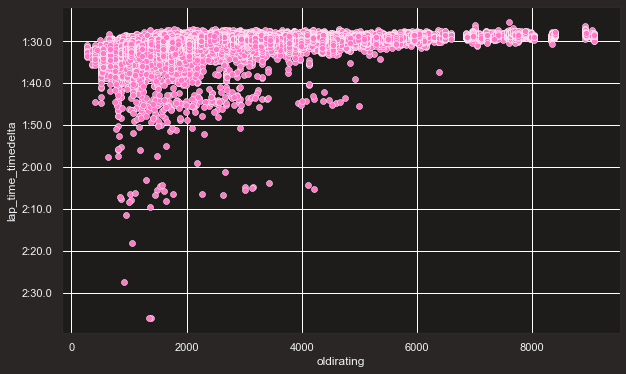

In [126]:
#we can also plot the laps vs irating, but it looks a bit messy, as there's tons of laps to analyze (over 127k!)
plt.rcParams['figure.figsize'] = [10, 6]
sns.scatterplot(data = iracing_data, x = 'oldirating', y = 'lap_time_timedelta', palette = "bright")

In [129]:
#there's something called cutoff time in F1, basically you have to be within 7% of the fastest time
#the fastest time in this dataset is quite quick, and we'd be eliminating a lot of laps if we just used this time.
min(iracing_data['lap_time_timedelta']) * 1.07

Timedelta('0 days 00:01:31.317866')

In [143]:
#so I'm going to use the mean instead and multiply it by 7%
cutoff_time_iracing = np.mean(iracing_data['lap_time_timedelta']) * 1.07
iracing_data_with_cutoff = iracing_data[iracing_data['lap_time_timedelta'] < cutoff_time_iracing]
iracing_data_with_cutoff = iracing_data_with_cutoff.reset_index(drop=True)
iracing_data_with_cutoff

,weather_temp_value,custid,oldirating,carid,lap_time,ccName,subsessionid,lapnum,flags,lap_time_timedelta
0,67.654999,10041,3022,145,90765.0,Mercedes-AMG+W12+E+Performance,43291524,2,0,0 days 00:01:30.765000
1,67.654999,10041,3022,145,89866.8,Mercedes-AMG+W12+E+Performance,43291524,3,0,0 days 00:01:29.866800
2,67.654999,10041,3022,145,90491.2,Mercedes-AMG+W12+E+Performance,43291524,4,0,0 days 00:01:30.491200
3,67.654999,10041,3022,145,90287.2,Mercedes-AMG+W12+E+Performance,43291524,5,0,0 days 00:01:30.287200
4,67.654999,10041,3022,145,92588.9,Mercedes-AMG+W12+E+Performance,43291524,6,0,0 days 00:01:32.588900
...,...,...,...,...,...,...,...,...,...,...
85520,69.697540,701801,2250,145,89307.2,Mercedes-AMG+W12+E+Performance,43372005,19,0,0 days 00:01:29.307200
85521,69.697540,701801,2250,145,89119.6,Mercedes-AMG+W12+E+Performance,43372005,20,0,0 days 00:01:29.119600
85522,69.697540,701801,2250,145,88867.2,Mercedes-AMG+W12+E+Performance,43372005,21,0,0 days 00:01:28.867200
85523,69.697540,701801,2250,145,88766.7,Mercedes-AMG+W12+E+Performance,43372005,26,0,0 days 00:01:28.766700


<AxesSubplot:xlabel='oldirating', ylabel='lap_time_timedelta'>

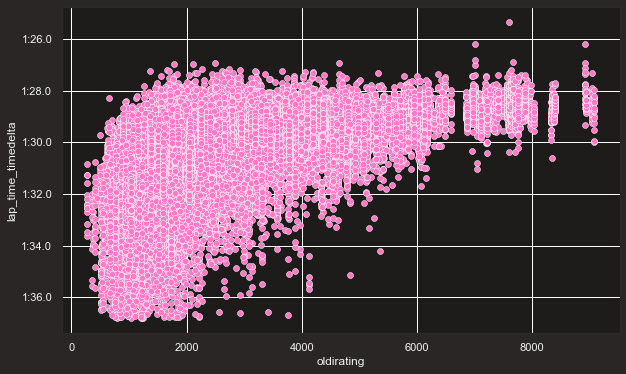

In [144]:
#plot this again, and we see a nicer graph that shows the distribution better.
plt.rcParams['figure.figsize'] = [10, 6]
sns.scatterplot(data = iracing_data_with_cutoff, x = 'oldirating', y = 'lap_time_timedelta', palette = "bright")

In [146]:
#let's do the same thing for the merc data set
f1_data_merc = f1_data[f1_data['Team'] == 'Mercedes']
cutoff_time_merc = min(f1_data_merc['LapTime']) * 1.07
f1_data_merc = f1_data_merc[f1_data_merc['LapTime'] < cutoff_time_merc]
f1_data_merc = f1_data_merc.reset_index(drop=True)
f1_data_merc

,DriverNumber,LapNumber,LapTime,Sector1Time,Sector2Time,Sector3Time,Team,Driver,Stint
0,44,5.0,0 days 00:01:33.049000,0 days 00:00:29.390000,0 days 00:00:38.032000,0 days 00:00:25.627000,Mercedes,HAM,2.0
1,44,6.0,0 days 00:01:33.113000,0 days 00:00:29.523000,0 days 00:00:38.109000,0 days 00:00:25.481000,Mercedes,HAM,2.0
2,44,7.0,0 days 00:01:32.738000,0 days 00:00:29.324000,0 days 00:00:37.952000,0 days 00:00:25.462000,Mercedes,HAM,2.0
3,44,8.0,0 days 00:01:32.928000,0 days 00:00:29.426000,0 days 00:00:37.924000,0 days 00:00:25.578000,Mercedes,HAM,2.0
4,44,9.0,0 days 00:01:33.013000,0 days 00:00:29.525000,0 days 00:00:37.892000,0 days 00:00:25.596000,Mercedes,HAM,2.0
...,...,...,...,...,...,...,...,...,...
89,77,48.0,0 days 00:01:31.181000,0 days 00:00:29.048000,0 days 00:00:36.932000,0 days 00:00:25.201000,Mercedes,BOT,3.0
90,77,49.0,0 days 00:01:31.473000,0 days 00:00:29.175000,0 days 00:00:37.246000,0 days 00:00:25.052000,Mercedes,BOT,3.0
91,77,50.0,0 days 00:01:32.153000,0 days 00:00:29.972000,0 days 00:00:37.139000,0 days 00:00:25.042000,Mercedes,BOT,3.0
92,77,51.0,0 days 00:01:31.698000,0 days 00:00:29.173000,0 days 00:00:37.225000,0 days 00:00:25.300000,Mercedes,BOT,3.0


legend      WARNING 	No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


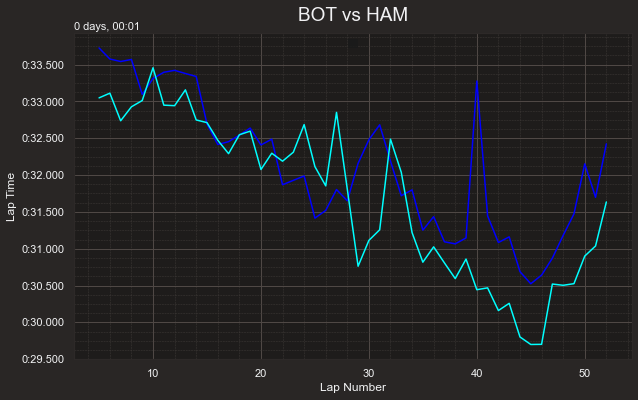

In [147]:
#this takes Merc's drivers and plots their times.
ham = f1_data_merc[f1_data_merc['Driver'] == "HAM"]
bot = f1_data_merc[f1_data_merc['Driver'] == "BOT"]
bot = bot.reset_index()
ham = ham.reset_index()

plt.rcParams['figure.figsize'] = [10, 6]
fig, ax = plt.subplots()

ax.plot(bot['LapNumber'], bot['LapTime'], color='blue')
ax.plot(ham['LapNumber'], ham['LapTime'], color='cyan')
ax.set(ylabel='Laptime', xlabel='Lap')
ax.legend(loc="upper center")
ax.set_title("BOT vs HAM")
ax.set_xlabel("Lap Number")
ax.set_ylabel("Lap Time")

plt.show()

In [ ]:
iracing_data.groupby(['custid']).count().nlargest(5, 'lapnum')

,weather_temp_value,oldirating,carid,lap_time,ccName,subsessionid,lapnum,flags,lap_time_timedelta
custid,,,,,,,,,
687383,398,398,398,398,398,398,398,398,398
184169,359,359,359,359,359,359,359,359,359
591460,353,353,353,353,353,353,353,353,353
189504,346,346,346,346,346,346,346,346,346
646927,335,335,335,335,335,335,335,335,335


In [ ]:
iracing_data_grouped_counts = iracing_data.groupby(['custid']).count().nlargest(10, 'lapnum')
iracing_data_grouped_counts.index

Int64Index([687383, 184169, 591460, 189504, 646927, 547465, 462672, 107253,
            166550, 355066],
           dtype='int64', name='custid')

In [ ]:
lap_data_most_driven = iracing_data[iracing_data['custid'] == 462672]
cutoff_time = min(lap_data_most_driven['lap_time'])*1.07
lap_data_most_driven = lap_data_most_driven[lap_data_most_driven['lap_time'] < cutoff_time]
lap_data_most_driven = lap_data_most_driven.reset_index()


In [ ]:
# we should probably do something with the mean
np.mean(iracing_data.oldirating), stats.mode(iracing_data.oldirating)[0][0]


(2470.067578392561, 1835)

<AxesSubplot:xlabel='oldirating', ylabel='lap_time_timedelta'>

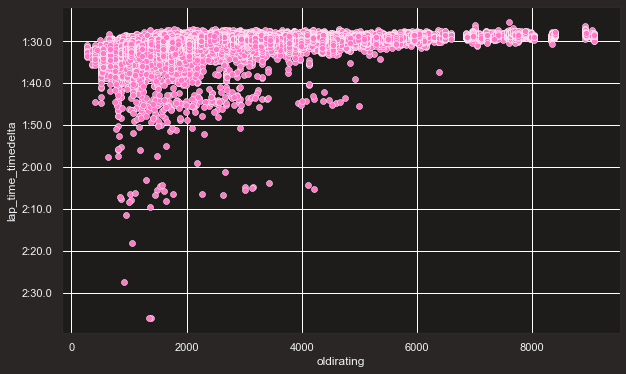

In [ ]:
iracing_data = iracing_data.reset_index()
sns.scatterplot(data = iracing_data, x = 'oldirating', y = 'lap_time_timedelta', palette = "bright")

legend      WARNING 	No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


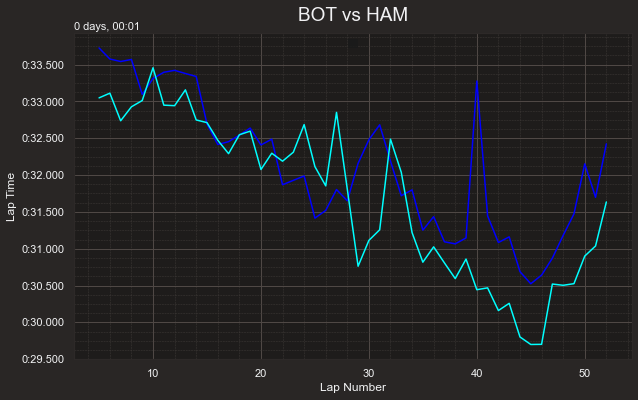

In [ ]:
plt.rcParams['figure.figsize'] = [10, 6]
fig, ax = plt.subplots()

ax.plot(bot['LapNumber'], bot['LapTime'], color='blue')
ax.plot(ham['LapNumber'], ham['LapTime'], color='cyan')
ax.set(ylabel='Laptime', xlabel='Lap')
ax.legend(loc="upper center")
ax.set_title("BOT vs HAM")
ax.set_xlabel("Lap Number")
ax.set_ylabel("Lap Time")

plt.show()

In [ ]:

iracing_data_grouped_counts


,weather_temp_value,oldirating,carid,lap_time,ccName,subsessionid,lapnum,flags,lap_time_timedelta
custid,,,,,,,,,
687383,398,398,398,398,398,398,398,398,398
184169,359,359,359,359,359,359,359,359,359
591460,353,353,353,353,353,353,353,353,353
189504,346,346,346,346,346,346,346,346,346
646927,335,335,335,335,335,335,335,335,335
547465,328,328,328,328,328,328,328,328,328
462672,307,307,307,307,307,307,307,307,307
107253,303,303,303,303,303,303,303,303,303
166550,301,301,301,301,301,301,301,301,301


KeyError: 0

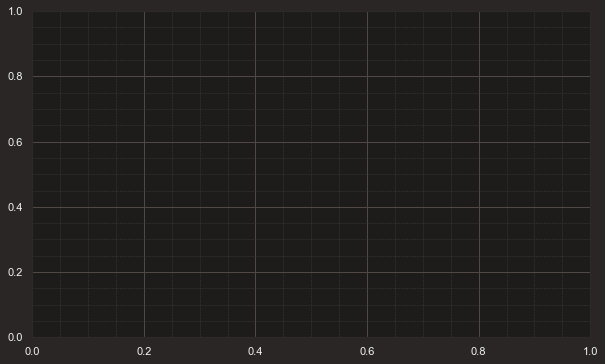

In [ ]:
fig, ax = plt.subplots()
sns.set(rc={'figure.figsize':(9,9)})
sns.histplot(data=iracing_data_grouped_counts, x="oldirating")